# Illustrating PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

ModuleNotFoundError: No module named 'seaborn'

## Making the data

We are going to illiustrate the use of PCA with a made up data set. You can imagine that these are events in a detector that are tagged with different types of results. In the default case there's 8 of those different events (could be decay channels in a experiment, or the results of classes of observations). The crtiical aspect is that there are many, many feautres in the data set...too many to really make sense of. In this case, we have 200 features, which is way too many to understand immediately.

Below, we've created that data set. We've tried to make it noisy with a bigger `cluster_std`, but remember that you are only able to see 2 or 3 of the 200 features at any one time.

In [2]:
## Preparing the set up
nSamples = 2000
nCenters = 8
nFeatures = 200
clusterStd = 4
RS = 42

# Create random dataset with many features
X, y = make_blobs(n_samples=nSamples, centers=nCenters, n_features=nFeatures, cluster_std=clusterStd, random_state=RS)

# Create a list of class labels for the confusion matrix visual
labels = np.arange(nCenters)

# # Print the list of labels
print(labels)

[0 1 2 3 4 5 6 7]


### Visualizing the confusion matrix

We have 8 potential classes. That is quite a few and makes the 2x2 matrix we were using in the past not relevant. There's seven ways to incorrectly classify these data! Below is a little function that takes the known and opredicted labels and demonstrates the quality of the fit. We will call this function later.

In [12]:
def multi_class_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.plasma, annot_kws={"size": 14})
    ax.set_xlabel('Predicted Label', fontsize=14, color='black')
    ax.set_ylabel('True Label', fontsize=14, color='black')
    ax.set_title('Confusion Matrix', fontsize=14, color='black')
    ax.tick_params(colors='black', labelsize=12)
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_yticklabels(labels, fontsize=12)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.show()

## Investgating the subspace

Note we can ony see 2-3 dimensions at any one time. Below, we plot the subsapce consisting of the first three features. But remember there's 200 features. The second plot is also 3D, but for features 52, 100, and 179. It probably seems really hard to know how this fit is going to work. Everything looks really messy.

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

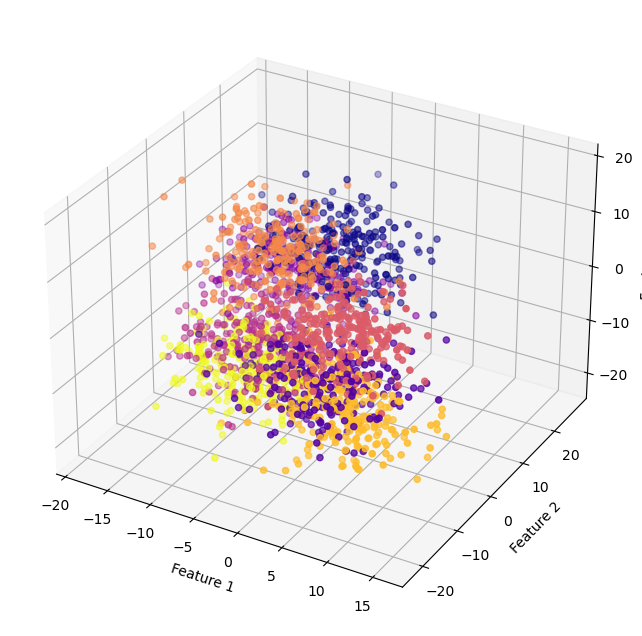

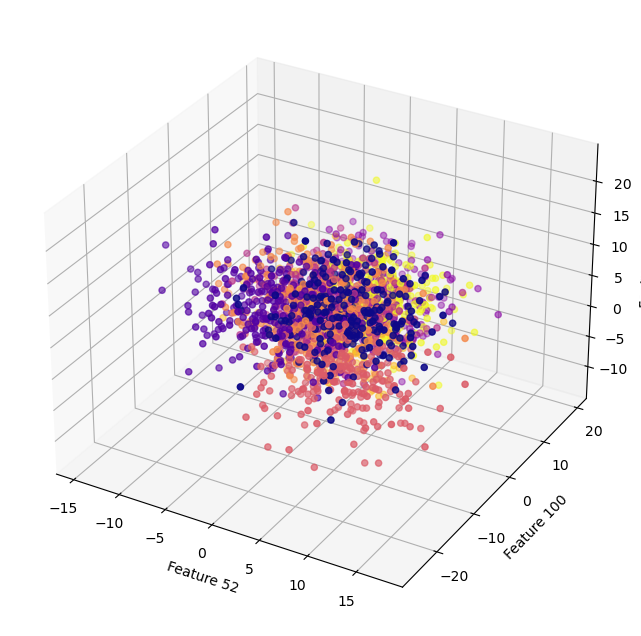

In [13]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap="plasma")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.tight_layout

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(projection="3d")

ax.scatter(X[:,51], X[:,99], X[:,178], c=y, cmap="plasma")
ax.set_xlabel("Feature 52")
ax.set_ylabel("Feature 100")
ax.set_zlabel("Feature 179")
plt.tight_layout

## Build a classifier model

Below, we use the `RandomForestClassifer` to illustrate the approach to making classifier models. Note the only input to a basic RF model is the number of trees in the forest. This relates to the depth of your forest, and you can think of this as being able to capture more nuanced splits or decisions. We should be able to reduce the number of tress and produce a less accurate model. We start with 100 trees, which is the default for `scikit`.

Notice the process is all the same as before. We illistrate a less accurate model by reducing the number of trees a lot. 

*Given the consistent quality of this fit with a low number of trees, my suspicion is that we are overfitting these data.*

In [14]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Train the model on the training set
rf.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Basic RF model: {accuracy:.3f}")

Accuracy of Basic RF model: 1.000


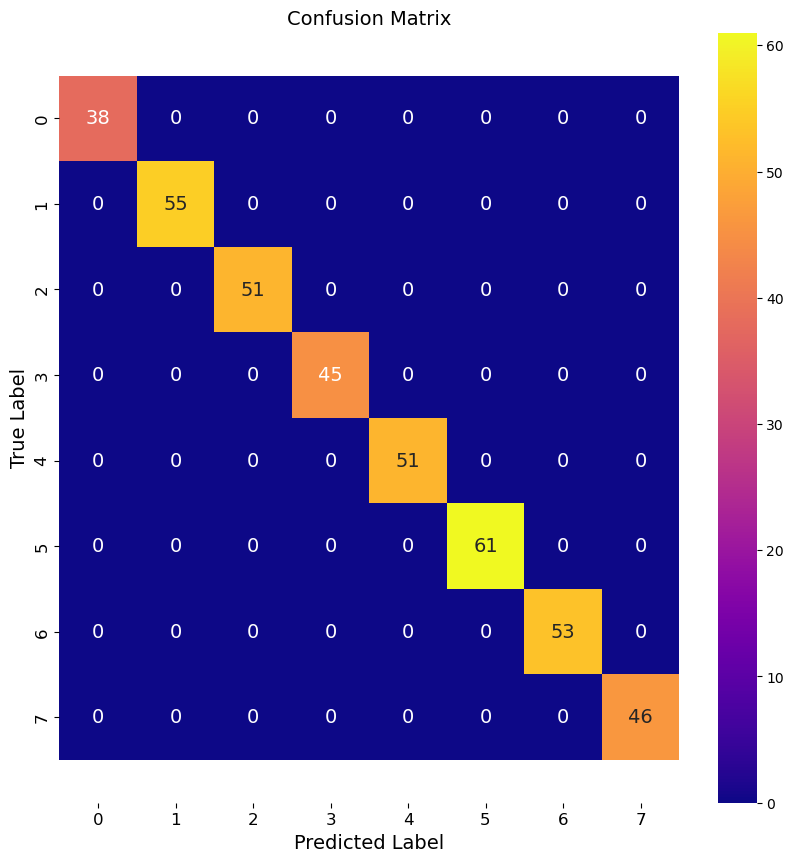

In [15]:
multi_class_confusion_matrix(y_test, y_pred, labels)

Accuracy of Low RF model: 0.975


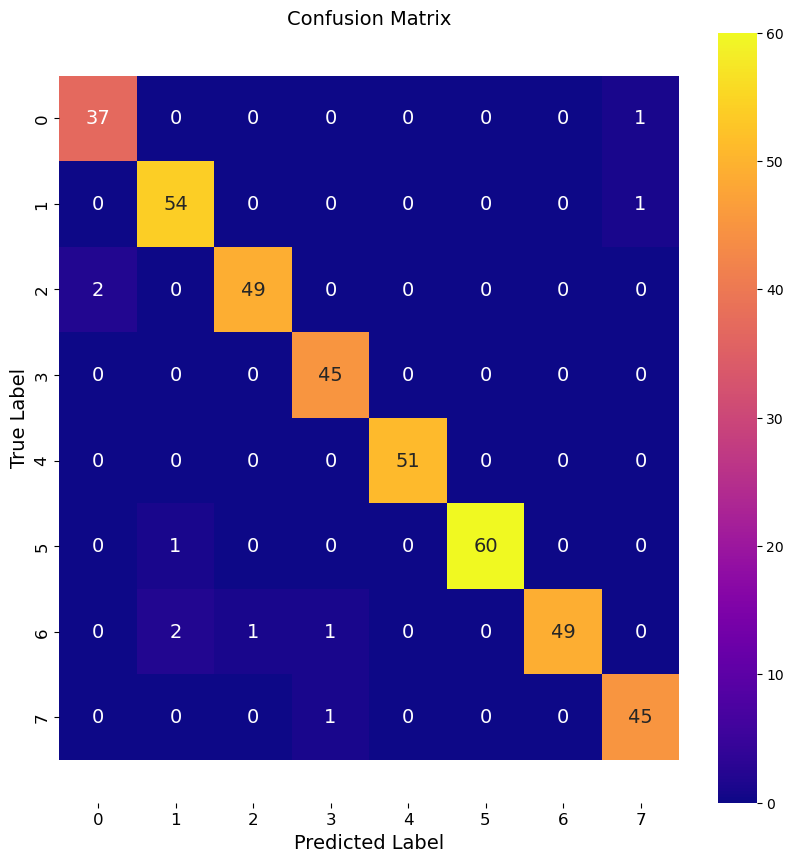

In [16]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize random forest classifier with 3 trees
rflow = RandomForestClassifier(n_estimators=3)

# Train the model on the training set
rflow.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = rflow.predict(X_test)

# Calculate accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of Low RF model: {accuracy:.3f}")
multi_class_confusion_matrix(y_test, y_pred, labels)

## Introduce the PCA

A PCA tries to find a combination of features that maximizes the variance that each new feature accounts for. We can see this by looking at subplots of the data before an after the PCA is done. To do a PCA, we must choose the number of components to reduce to. Remember that we have 200 features, so our goal is to produce a reaonably accurate model with much fewer features. Two is the lowest number one should start with, but the work you do will inform this decision. There's also plenty of research on how to choose the number of features to include. Much of this relies on what is called the [Scree Plot](https://en.wikipedia.org/wiki/Scree_plot).

Below, we form a PCA object with only 2 features instead of 200. We reun the PCA, fit the data, and then compare two subspace plots. 

**Note there are ONLY two features in the PCA data, so the subspace plot is complete!**

Text(0.5, 1.0, 'After PCA')

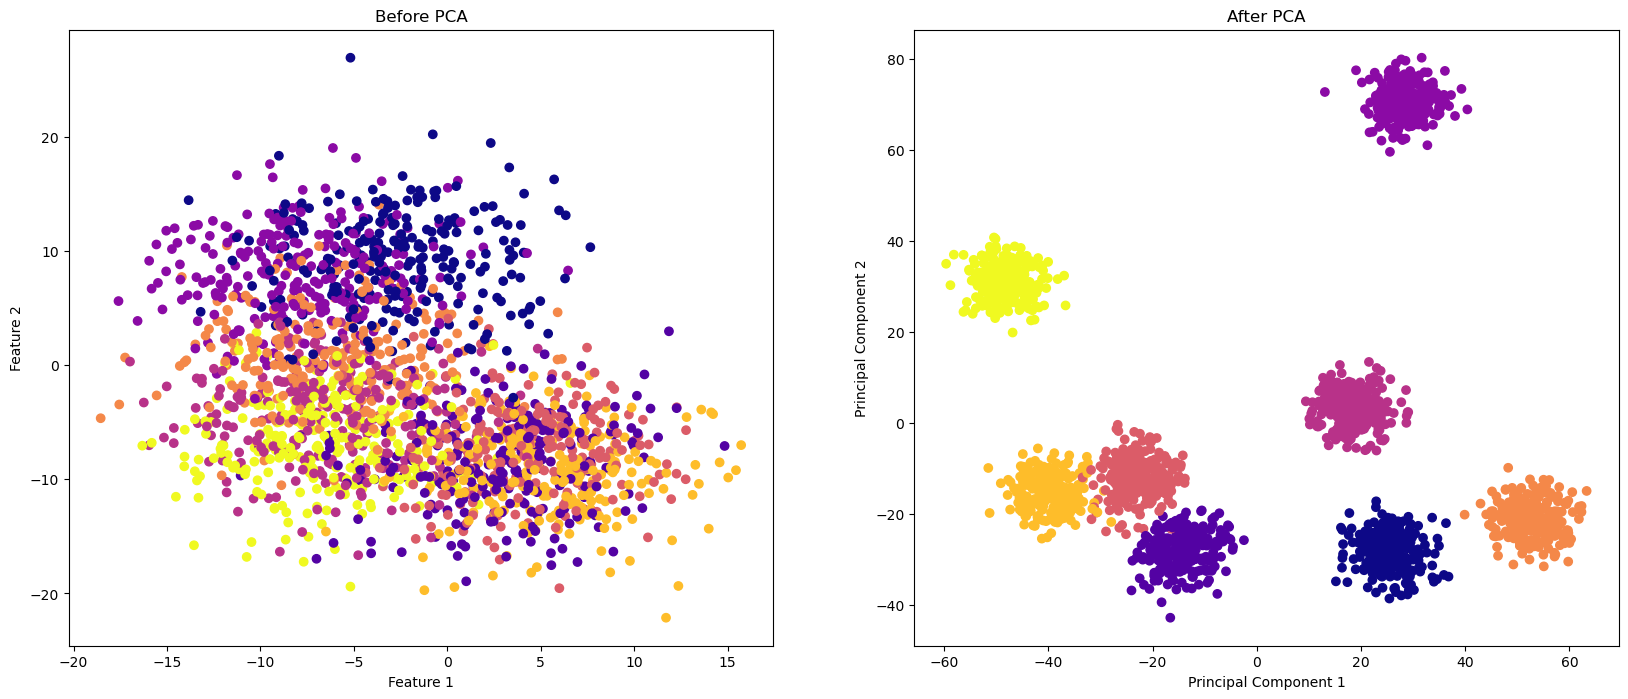

In [17]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

# Plot the dataset before PCA
axs[0].scatter(X[:,0], X[:,1], c=y, cmap="plasma")
axs[0].set_xlabel("Feature 1")
axs[0].set_ylabel("Feature 2")
axs[0].set_title("Before PCA")

# Plot the dataset after PCA
axs[1].scatter(X_pca[:,0], X_pca[:,1], c=y, cmap="plasma")
axs[1].set_xlabel("Principal Component 1")
axs[1].set_ylabel("Principal Component 2")
axs[1].set_title("After PCA")

## Build a model using PCA data

See below, we follow the same process, except now we use the `X_pca` input features, remember there's only two features in that data. We run the same RF algorithm.

Accuracy of PCA RF model (2 features): 0.990


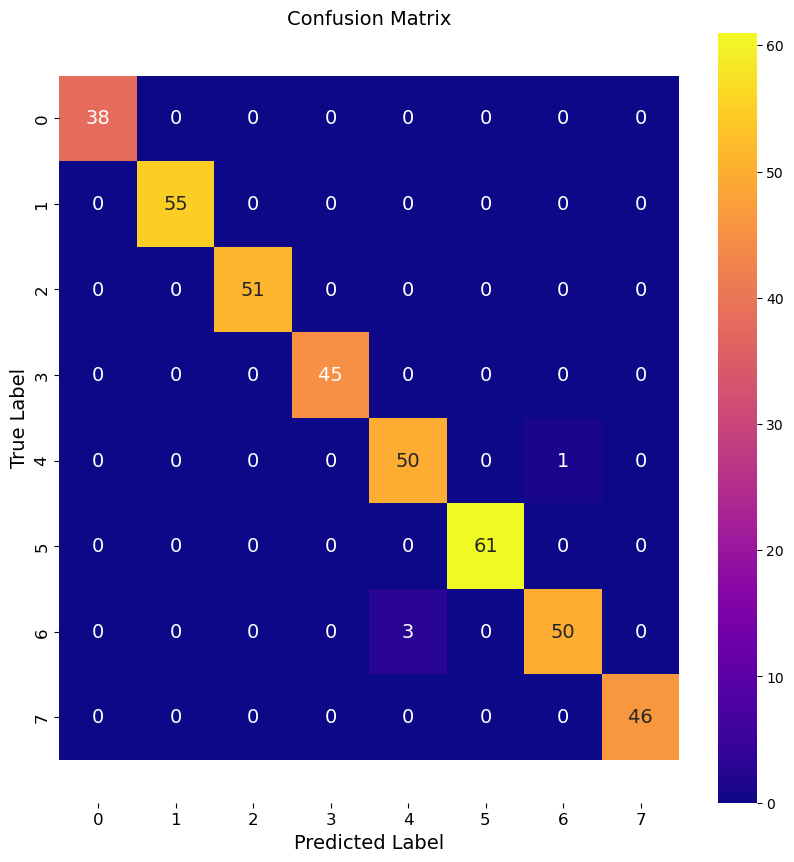

In [20]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Initialize random forest classifier with 100 trees
rf = RandomForestClassifier(n_estimators=100)

# Train the model on the training set
rf.fit(X_train, y_train)

# Use the model to make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate accuracy of predictions
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy of PCA RF model (2 features): {accuracy:.3f}")
multi_class_confusion_matrix(y_test, y_pred, labels)

## Things to try

1. How do other classifiers perform? Do you have to consider certain parameters or issues in setting them up? Think about how many features and classes you have.
2. Can you generate a data set that fits poorly on initial run? Think about all the parameters we can adjust. Does PCA help?
4. Can you repeat our analysis here for a regression problem instead? `make_regression` can make those data.

Alternatively, you can start on the PCA notebook with the cancer data.